##### "Remaining Useful Life Estimation in Prognostics Using Deep Convolution Neural Networks" by Xiang Li et al.

This document reproduces the implementation of a Deep Convolutional Network  by Xiang Li et al. applied to the NASA "CMAPSS" dataset. This implementation has been done in Keras. The supporting text comes from the corresponding paper.

Copyright (c) by Manuel Arias, Christian Schneebeli and Lukas R. Peter 2017-12-01.

Before jumping into the problem, let's run the cell below to load the required packages.

In [1]:
import os
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import Dropout
from keras.models import Model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.initializers import glorot_uniform
from keras import optimizers
from IPython.display import SVG, clear_output
from keras.utils import plot_model
from os import path

import keras.callbacks
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# 1  "CMAPSS" Dataset

The C-MAPSS dataset FD001 from NASA was used to evaluate our model. This dataset provides degradation trajectories of 100 turbofan engines with unknown and different initial health condition for one operative set-point and one failure mode. The data were synthetically generated with the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dynamical model. The training data contains multivariate sensors readings of the complete run-to-failure trajectories. Therefore, the records stop at the cycle/time the engine failed. For the test set truncated time-series of various lengths prior to failure are provided for 100 engines. A total number of 20k and 13k cycles are available for the training and test set respectively.


**Details of the "CMAPSS" dataset**
- Training: 17731 inputs from 100 engine trajectories. It uses a sliding time window of 30 time stamps. 
- Test: 100 points from 100 engine trajectories. It takes the last available 30 time stamps.

# 1.1  Data Pre-processing

As proposed in Li, we follow a three-step process to create the input sequences to LSTM and CNN models. Since the FD001 dataset is limited to one operative condition, 10 out of the 24 sensors show constant values. Therefore, we first dropped these values and we normalized the other 14 sensors by min/max-normalization to a range $[-1, 1]$. Second, the original dataset was processed with a sliding time window approach of size $N_f = 30$ and stride of 1. The sliding window means that the first input sample to the network takes measurements from cycles 1-30, the second 2-31, the third 3-32, and so on for each unit of the fleet. The RUL label for a sample is then simply the total number of cycles of the engine is able to operate minus the cycle where the window ends. As discussed in Li, we use a window size of 30 cycles/times since the smallest test sample consists of 30 cycles. This approach provides 17731 training samples. Lastly, the maximum horizon of prediction for RUL i.e $R_{early}$ was limited to 125 cycles following the standard procedure adopted by other researchers Li, Malhotra. This has a noticeable impact on the model accuracy and makes our models more stable. From a practical point of view, it implies that we are not interested in prediction RUL further away than 125 cycles ahead.

**Time window details**
- $N_{tw} = 30$ 
- Stride = 1

In [3]:
def sliding_window(data, N_tw = 30, stride = 1):
    N_en = np.unique(data[:,0]).shape[0]                            # Number of engines (N_en)
    m = 0
    for i in range(N_en):
        n_H   = data[data[:,0] == i+1,0].shape[0]
        N_sw  = int((n_H- N_tw) / stride + 1)                       # Number of sliding windows for engine 'i' 
        for h in range(N_sw):
            m = m + 1    
    return m, N_en        

In [4]:
#old

In [5]:
#print (train_set)
#print ("train_set shape: " + str(train_set.shape))
#print (train_set_x_org)
#print (train_set_c)
#print ("train_set_x_org shape: " + str(train_set_x_org.shape))
#print ("X_train shape: " + str(train_x.shape))
#print ("Y_train shape: " + str(train_y.shape))
#print ("X_test shape: " + str(test_x.shape))
#print ("Y_test shape: " + str(test_y.shape))
#print ("-------------------------------------------------------")
#print ("Rearly: " +str(R_early))
#for i in range(0,46218):
#    print (Y_train[i])

#print ("X_train : " + str(train_x))
#print ("Y_train : " + str(train_y))
#print ("X_test : " + str(test_x))
#print ("Y_test : " + str(test_y))


In [6]:
def load_dataset(N_tw, stride, sel, R_early):
    # Load training data
    basepath        = path.dirname(os.getcwd()) 
    train_set       = np.loadtxt(path.abspath(path.join(basepath, "data", "train_FD002.txt")))  # Training set
    train_set_x_org = train_set[:,sel]                              # Training set input space (x)    
    train_set_c     = train_set[:,np.array([1])]                    # Training set cycles (c)
    
    # Normalize the data
    ub = train_set_x_org.max(0)
    lb = train_set_x_org.min(0)    
    train_set_x = 2 * (train_set_x_org - lb) / (ub - lb) - 1   
   
    N_ft    = sel.shape[0]                                           # Nunber of features (N_ft)
    m, N_en = sliding_window(train_set, N_tw, stride)                # Number of training data & engines
    
    train_x = np.empty((m, N_tw, N_ft, 1), float)
    train_y = np.empty((m, 1), float)
    
    k = 0
    for i in range(N_en):
        idx       = train_set[:,0] == i+1                            # Index for engine number 'i'
        train_i_x = train_set_x[idx,:]                               # Engine 'i' training  data
        train_i_c = train_set_c[idx]                                 # Engine 'i' cycles (c)
        train_i_y = train_i_c[-1] - train_i_c                        # RUL: Remaining Useful Lifetime for engine 'i'
        train_i_y[train_i_y > R_early] = R_early                     # R_early = 125
        N_sw      = int((train_i_x.shape[0] - N_tw) / stride + 1)    # Number of sliding windows for engine 'i' 
        for h in range(N_sw):
            k = k + 1
            vert_start = h * stride
            vert_end   = h * stride + N_tw
            train_i_x_slice = train_i_x[vert_start:vert_end,:]       # Training input data for engine 'i' on time window 'h'
            train_i_y_slice = train_i_y[vert_end-1,:]                # Training output data for engine 'i' on time window 'h'
            train_i_x_slice.shape = (N_tw, N_ft, 1)                  # Reshape training set input (N_tw, N_ft, 1)
            train_i_y_slice.shape = (1, 1)                           # Reshape training set output (1, 1)
            train_x[k-1,:,:] = train_i_x_slice
            train_y[k-1,:] = train_i_y_slice
     
    # Load test data
    test_set       = np.loadtxt(path.abspath(path.join(basepath, "data", "test_FD002.txt")))
    test_set_x_org = test_set[:,sel]                                 # Test set input space (x)
    test_set_c     = test_set[:,np.array([1])]                       # Test set cycles (c)
    test_y         = np.loadtxt(path.abspath(path.join(basepath, "data", "RUL_FD002.txt")))    # Test set RUL (c)
    test_y.shape   = (test_y.shape[0], 1)
    
    # Normalize the data
    test_set_x = 2 * (test_set_x_org - lb) / (ub - lb) - 1   
    
    m_ts, N_en_ts = sliding_window(test_set, N_tw, stride)           # Number of training data & engines
    
    test_x = np.empty((N_en_ts, N_tw, N_ft, 1), float)
    
    k = 0
    for ii in range(N_en_ts):
        engine         = test_set[:,0] == ii+1                       # Index for engine number 'i'
        test_i_x       = test_set_x[engine,:]                        # Engine 'i' test  data
        test_i_x_slice = test_i_x[-N_tw:,:]                          # Training input data for engine 'i' on time window 'h'
        test_i_x_slice.shape = (N_tw, N_ft, 1)                       # Reshape training set input (N_tw, N_ft, 1)
        test_x[ii,:,:] = test_i_x_slice
    
    return train_x, train_y, test_x, test_y

In [7]:
#N_tw     = 30                                                               # Time Window (N_tw)
#said to be the smallest running time of set, set to 20  (21 still possible) from 30
N_tw     = 20
#R_early  = 125                                                              # Max RUL in training set
R_early  = 179 #max in FD002 !!!   
stride   = 1
sel      = np.array([6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25])  # Index of input features

In [8]:
X_train, Y_train, X_test, Y_test = load_dataset(N_tw, stride, sel, R_early)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 48819
number of test examples = 259
X_train shape: (48819, 20, 14, 1)
Y_train shape: (48819, 1)
X_test shape: (259, 20, 14, 1)
Y_test shape: (259, 1)


# 2  Network Structure

The network uses five convolutional layers with filters of size $10 \times 1$. The first four convolutions have ten channels and the last convolution has only one filter. Zero padding is used to keep the feature map through the network. The resulting 2D feature map is flattened and the network ends with a 100-way fully connected layer followed by a linear output neuron. The network incorporates dropout as regularized and use tanh as the activation function. The resulting network has around 45k trainable parameters. Since the code from Li is not publicly available, a re-implementation of the solution was required.

**Model Hyperparameters:**


In [9]:
# Kernel size
kernels = [10, 10, 10, 10, 3]

# Number of filters (channels)
filters = [10, 10, 10, 10, 1]

# Activation
activ = 'tanh'

# 3  Model in Keras


In [10]:
def CNN_2d(input_shape, filters, kernels, activ):
    """
    Implementation of the model.
    
    Arguments:
    input_shape -- shape of the images of the dataset
    filters -- number of channels of each convolution layer
    kernels -- kernel size of 1D filters for each convolution layer

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Retrieve Filters & kernels
    F0, F1, F2, F3, F4 = filters                 
    K0, K1, K2, K3, K4 = kernels    
      
    # Define the input placeholder as a tensor with shape input_shape    
    X_input = Input(input_shape)
   
    # CONV -> RELU Block applied to X_input
    X = Conv2D(F0, (K0, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv0')(X_input)
    
    # CONV -> RELU Block applied to X
    X = Conv2D(F1, (K1, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv1')(X)
      
    # CONV -> RELU Block applied to X
    X = Conv2D(F2, (K2, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv2')(X)
        
    # CONV -> RELU Block applied to X
    X = Conv2D(F3, (K3, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv3')(X)
      
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(F4, (K4, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv4')(X)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    X = Dense(100, activation = activ, name='fc')(X)
    X = Dense(1, name='RUL')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='CNN_2d')    
   
    return model

Now, we feed the model hyperparameters to the CNN model

In [11]:
# Call the model
CNN_2d = CNN_2d(X_train.shape[1:],filters, kernels, activ)

In [12]:
print ("Rearly: " +str(R_early))
for i in range(0,46218):
    print (Y_train[i])

Rearly: 358
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[249.]
[248.]
[247.]
[246.]
[245.]
[244.]
[243.]
[242.]
[241.]
[240.]
[239.]
[238.]
[237.]
[236.]
[235.]
[234.]
[233.]
[232.]
[231.]
[230.]
[229.]
[228.]
[227.]
[226.]
[225.]
[224.]
[223.]

[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[251.]
[250.]
[249.]
[248.]
[247.]
[246.]
[245.]
[244.]
[243.]
[242.]
[241.]
[240.]
[239.]
[238.]
[237.]
[236.]
[235.]
[234.]
[233.]
[232.]
[231.]
[230.]
[229.]
[228.]
[227.]
[226.]
[225.]
[224.]
[223.]
[222.]
[221.]
[220.]
[219.]
[218.]
[217.]
[216.]
[215.]
[214.]
[213.]
[212.]
[211.]
[210.]
[209.]
[208.]
[207.]
[206.]
[205.]
[204.]
[203.]
[202.]
[201.]
[200.]
[199.]
[198.]
[197.]
[196.]
[195.]
[194.]
[193.]
[192.]
[191.]
[190.]
[189.]
[188.]
[187.]
[186.]
[185.]
[184.]
[183.]
[182.]
[181.]
[180.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[

[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.

[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68

[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[183.]
[182.]
[181.]
[180.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[3

[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[185.]
[184.]
[183.]
[182.]
[181.]
[180.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]


[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[273.]
[272.]
[271.]
[270.]
[269.]
[268.]
[267.]
[266.]
[265.]
[264.]
[263.]
[262.]
[261.]
[260.]
[259.]
[258.]
[257.]
[256.]
[255.]
[254.]
[253.]
[252.]
[251.]
[250.]
[249.]
[248.]
[247.]
[246.]
[245.]
[244.]
[243.]
[242.]
[241.]
[240.]
[239.]
[238.]
[237.]
[236.]
[235.]
[234.]
[233.]
[232.]
[231.]
[230.]
[229.]
[228.]
[227.]
[226.]
[225.]
[224.]
[223.]
[222.]
[221.]
[220.]
[219.]
[218.]
[217.]
[216.]
[215.]
[214.]
[213.]
[212.]
[211.]
[210.]
[209.]
[208.]
[207.]
[206.]
[205.]
[204.]
[203.]
[202.]
[201.]
[200.]
[199.]
[198.]
[197.]
[196.]
[195.]
[194.]
[193.]
[192.]
[191.]
[190.]
[189.]
[188.]
[187.]
[186.]
[185.]
[184.]
[1

[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137

[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129

[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[268.]
[267.]
[266.]
[265.]
[264.]
[263.]
[262.]
[261.]
[260.]
[259.]
[258.]
[257.]
[256.]
[255.]
[254.]
[253.]
[252.]
[251.]
[250.]
[249.]
[248.]
[247.]
[246.]
[245.]
[244.]
[243.]
[242.]
[241.]
[240.]
[239.]
[238.]
[237.]
[236.]
[235.]
[234.]
[233.]
[232.]
[231.]
[230.]
[229.]
[228.]
[227.]
[226.]
[225.]
[224.]
[223.]
[222.]
[221.]
[220.]
[219.]
[218.]
[217.]
[216.]
[215.]
[214.]
[213.]
[212.]
[211.]
[210.]
[209.]
[208.]
[207.]
[206.]
[205.]
[204.]
[203.]
[202.]
[201.]
[200.]
[199.]
[198.]
[197.]
[196.]
[195.]
[194.]
[193.]
[192.]
[191.]
[190.]
[189.]
[188.]
[187.]
[186.]
[185.]
[184.]
[183.]
[182.]
[181.]
[180.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.

[214.]
[213.]
[212.]
[211.]
[210.]
[209.]
[208.]
[207.]
[206.]
[205.]
[204.]
[203.]
[202.]
[201.]
[200.]
[199.]
[198.]
[197.]
[196.]
[195.]
[194.]
[193.]
[192.]
[191.]
[190.]
[189.]
[188.]
[187.]
[186.]
[185.]
[184.]
[183.]
[182.]
[181.]
[180.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67

[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]


[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.

[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[180.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]

[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[324.]
[323.]
[322.]
[321.]
[320.]
[319.]
[318.]
[317.]
[316.]
[315.]
[314.]
[313.]
[312.]
[311.]
[310.]
[309.]
[308.]
[307.]
[306.]
[305.]
[304.]
[303.]
[302.]
[301.]
[300.]
[299.]
[298.]
[297.]
[296.]
[295.]
[294.]
[293.]
[292.]
[291.]
[290.]
[289.]
[288.]
[287.]
[286.]
[285.]
[284.]
[283.]
[282.]
[281.]
[280.]
[279.]
[278

[3.]
[2.]
[1.]
[0.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]


[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.

[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[194.]
[193.]
[192.]
[191.]
[190.]
[189.]
[188.]
[187.]
[186.]
[185.]
[184.]
[183.]
[182.]
[181.]
[180.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174

[184.]
[183.]
[182.]
[181.]
[180.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32

[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[206.]
[205.]
[204.]
[203.]
[202.]
[201.]
[200.]
[199

[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167

[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138

[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]

[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[

[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36

[205.]
[204.]
[203.]
[202.]
[201.]
[200.]
[199.]
[198.]
[197.]
[196.]
[195.]
[194.]
[193.]
[192.]
[191.]
[190.]
[189.]
[188.]
[187.]
[186.]
[185.]
[184.]
[183.]
[182.]
[181.]
[180.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]


[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[194.]
[193.]
[192.]
[191.]
[190.]
[189.]
[188.]
[187.]
[186.]
[185.]
[184.]
[183.]
[182.]
[181.]
[180.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159

[190.]
[189.]
[188.]
[187.]
[186.]
[185.]
[184.]
[183.]
[182.]
[181.]
[180.]
[179.]
[178.]
[177.]
[176.]
[175.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39

[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[

[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]
[95.]
[94.]
[93.]
[92.]
[91.]
[90.]
[89.]
[88.]
[87.]
[86.]
[85.]
[84.]
[83.]
[82.]
[81.]
[80.]
[79.]
[78.]
[77.]
[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[246.]
[245.]
[244.]
[243.]
[242.]
[241.]
[240.]
[239.]
[238.]
[237.]
[236.]
[235.]
[234.]
[233.]
[232

[76.]
[75.]
[74.]
[73.]
[72.]
[71.]
[70.]
[69.]
[68.]
[67.]
[66.]
[65.]
[64.]
[63.]
[62.]
[61.]
[60.]
[59.]
[58.]
[57.]
[56.]
[55.]
[54.]
[53.]
[52.]
[51.]
[50.]
[49.]
[48.]
[47.]
[46.]
[45.]
[44.]
[43.]
[42.]
[41.]
[40.]
[39.]
[38.]
[37.]
[36.]
[35.]
[34.]
[33.]
[32.]
[31.]
[30.]
[29.]
[28.]
[27.]
[26.]
[25.]
[24.]
[23.]
[22.]
[21.]
[20.]
[19.]
[18.]
[17.]
[16.]
[15.]
[14.]
[13.]
[12.]
[11.]
[10.]
[9.]
[8.]
[7.]
[6.]
[5.]
[4.]
[3.]
[2.]
[1.]
[0.]
[174.]
[173.]
[172.]
[171.]
[170.]
[169.]
[168.]
[167.]
[166.]
[165.]
[164.]
[163.]
[162.]
[161.]
[160.]
[159.]
[158.]
[157.]
[156.]
[155.]
[154.]
[153.]
[152.]
[151.]
[150.]
[149.]
[148.]
[147.]
[146.]
[145.]
[144.]
[143.]
[142.]
[141.]
[140.]
[139.]
[138.]
[137.]
[136.]
[135.]
[134.]
[133.]
[132.]
[131.]
[130.]
[129.]
[128.]
[127.]
[126.]
[125.]
[124.]
[123.]
[122.]
[121.]
[120.]
[119.]
[118.]
[117.]
[116.]
[115.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[107.]
[106.]
[105.]
[104.]
[103.]
[102.]
[101.]
[100.]
[99.]
[98.]
[97.]
[96.]

## 3.1 Model Summary

In [13]:
CNN_2d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 14, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 20, 14, 10)        110       
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 14, 10)        1010      
_________________________________________________________________
conv2 (Conv2D)               (None, 20, 14, 10)        1010      
_________________________________________________________________
conv3 (Conv2D)               (None, 20, 14, 10)        1010      
_________________________________________________________________
conv4 (Conv2D)               (None, 20, 14, 1)         31        
_________________________________________________________________
flatten_1 (Flatten)          (None, 280)               0         
__________

## 3.2 Model Training

Its configuration is determined including the number of hidden layers, convolution filter number and length etc. The DCNN takes as the inputs the normalized training data, and the labeled RUL values for the training samples are used as the target outputs of the network

The optimization of the network's weights was carried out with mini-batch stochastic gradient descent (SGD) and with the Adam algorithm. Xavier initializer is used for the weight initializations. The learning rate was set to 0.001 and was kept constant for the whole 250 epochs.

In [14]:
CNN_2d.compile(optimizer = "Adam", loss = "mean_squared_error")

** Learning rate:**

In [15]:
print('Learning Rate: ' + str(K.get_value(CNN_2d.optimizer.lr)))

Learning Rate: 0.001


We define an updatable plot to track training evolution

In [16]:
# updatable plot
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, np.sqrt(self.losses), label="loss")
        plt.plot(self.x, np.sqrt(self.val_losses), label="val_loss")
        plt.ylabel('loss - RMSE')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper  left')
        plt.title('model loss')
        plt.show();
        
plot_losses = PlotLosses()

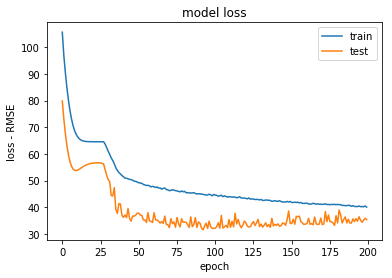

In [17]:
CNN_2d.fit(X_train, Y_train, epochs = 200, batch_size = 512, validation_data = (X_test, Y_test), callbacks=[plot_losses])

In [18]:
K.set_value(CNN_2d.optimizer.lr,0.0001)

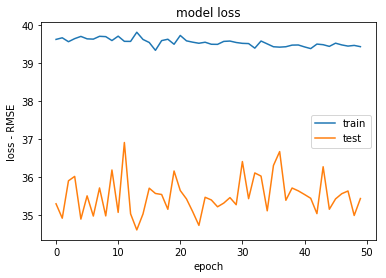

In [19]:
CNN_2d.fit(X_train, Y_train, epochs = 50, batch_size = 512, validation_data = (X_test, Y_test), callbacks=[plot_losses])

** Learning rate:**

In [20]:
print('Learning Rate: ' + str(K.get_value(CNN_2d.optimizer.lr)))

Learning Rate: 1e-04


In [21]:
max(Y_train)


array([358.])

In [22]:
max(Y_test)

array([194.])

Save the model (architecture, weights, ...) 

In [23]:
CNN_2d.save('FD002-5-layer-CNN.h5_R_early_179') 

# 4 Experimental Results

## 4.1 Performance Metrics
Three metrics were considered to compare our results: time of training, RMSE and the scoring function proposed in NASAdata. The scoring function $s$ is defined as follows.

\begin{align} \label{eq:someequation}
 s &= \sum_{i=1}^{N_{s}} exp(\alpha|\Delta_i|) 
\end{align}
Here $N_s$ denotes the total number of data samples, $\Delta_i$ is the difference between the estimated and real RUL and $\alpha$ is $\frac{1}{13}$ if we under-estimate and $\frac{1}{10}$ otherwise. Thus, this metric penalizes over-estimation more than under-estimation.

We use the standard definition of the root-mean-square error (RMSE).


In [24]:
def score_cal(y_hat, Y_test):
    d   = y_hat - Y_test
    tmp = np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        if d[i,0] >= 0:
           tmp[i] = np.exp( d[i,0]/10) - 1
        else:
           tmp[i] = np.exp(-d[i,0]/13) - 1
    return tmp 

Another popular metric to evaluate the effectiveness of the proposed method is Root Mean Square Error (RMSE).

## 4.2 Training set

In [25]:
preds = CNN_2d.evaluate(x = X_train, y = Y_train)
print()
print ("Test  MSE = " + str(preds))
print ("Test RMSE = " + str(np.sqrt(preds)))

48819/48819 [==============================] - 51s 1ms/step
()
Test  MSE = 1352.6286320434438
Test RMSE = 36.778099897132314


In [26]:
y_hat_tr   = CNN_2d.predict(x = X_train)

In [27]:
score_i_tr = score_cal(y_hat_tr, Y_train)

In [28]:
score_tr = "Score =" + str(sum(score_i_tr))

In [29]:
score_tr

'Score =176136510.93775126'

In [30]:
#score_tr = print ("Score = " + str(sum(score_i_tr)))


### 4.2.1 Plots

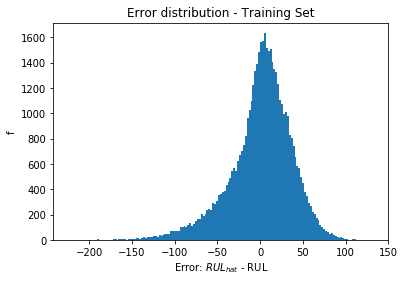

In [31]:
d_tr = y_hat_tr - Y_train
plt.hist(d_tr, bins='auto')  
plt.title('Error distribution - Training Set')
plt.ylabel('f')
plt.xlabel("Error: $RUL_{hat}$ - RUL")
plt.show()

## 4.3 Test set

In [32]:
#y_hat   = CNN_2d.predict(x = X_test)
#score_i = score_cal(y_hat, Y_test)
#score   = print("Score = " + str(sum(score_i)))

In [33]:
y_hat   = CNN_2d.predict(x = X_test)
score_i = score_cal(y_hat, Y_test)
score   = "Score = " + str(sum(score_i))
score

'Score = 134621.3546351315'

In [34]:
preds = CNN_2d.evaluate(x = X_test, y = Y_test)
print()
print ("MSE = " + str(preds))
print ("RMSE = " + str(np.sqrt(preds)))

259/259 [==============================] - 0s 1ms/step
()
MSE = 1256.1497600069376
RMSE = 35.44220309189227


### 4.3.1 Plots

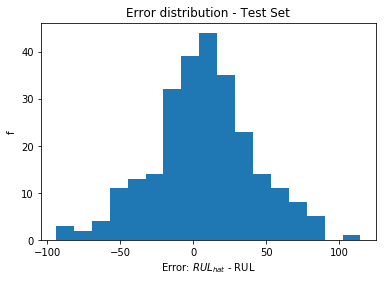

In [35]:
d = y_hat - Y_test
plt.hist(d, bins='auto')  
plt.title('Error distribution - Test Set')
plt.ylabel('f')
plt.xlabel("Error: $RUL_{hat}$ - RUL")
plt.show()

In [36]:
Y_test.shape

(259, 1)

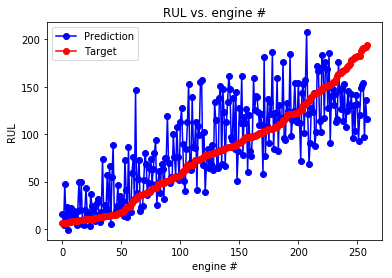

In [37]:
#x     = range(0,100)
x     = range(0,259) #fd002 has 259 samples
y_ts  = np.sort(Y_test[:,0])
idx   = np.argsort(Y_test[:,0])
y_tr  = y_hat[idx,0]
plt.plot(x, y_tr, 'bo-', x, y_ts, 'ro-')
plt.title('RUL vs. engine #')
plt.ylabel('RUL')
plt.xlabel('engine #')
plt.legend(['Prediction', 'Target'], loc='upper left')
plt.show()

In [38]:
X_test



array([[[[ 0.33370034],
         [ 0.32379791],
         [ 0.1504838 ],
         ...,
         [ 0.33333333],
         [-0.02537723],
         [-0.01360668]],

        [[-0.73630608],
         [-0.37412976],
         [-0.46300486],
         ...,
         [-0.39583333],
         [-0.97668038],
         [-0.96637011]],

        [[-0.62069915],
         [-0.29389137],
         [-0.45862418],
         ...,
         [-0.33333333],
         [-0.67695473],
         [-0.65877494]],

        ...,

        [[-0.96348289],
         [-0.89505621],
         [-0.85774804],
         ...,
         [-0.85416667],
         [-0.72153635],
         [-0.71035746]],

        [[-0.72969997],
         [-0.39704727],
         [-0.46478602],
         ...,
         [-0.375     ],
         [-0.98765432],
         [-0.96807663]],

        [[ 0.28250298],
         [ 0.46970066],
         [ 0.45044048],
         ...,
         [ 0.41666667],
         [ 0.24279835],
         [ 0.26088193]]],


       [[[ 0.26965777],


In [39]:
max(y_tr)

207.59283

In [40]:
max(y_ts)

194.0

max(y_ts)

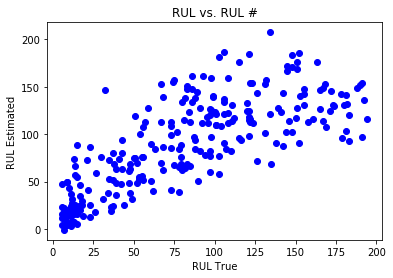

In [41]:
plt.plot(Y_test, y_hat, 'bo')
plt.title('RUL vs. RUL #')
plt.ylabel('RUL Estimated')
plt.xlabel('RUL True')
plt.show()

# 5 Conclusions

In [42]:
K.tensorflow_backend._get_available_gpus()

[]

In [43]:
Y_test[Y_test > R_early] = R_early                     # R_early = 125 or other, see above 
preds = CNN_2d.evaluate(x = X_test, y = Y_test)
print()
print ("MSE = " + str(preds))
print ("RMSE = " + str(np.sqrt(preds)))

259/259 [==============================] - 0s 1ms/step
()
MSE = 1256.1497600069376
RMSE = 35.44220309189227


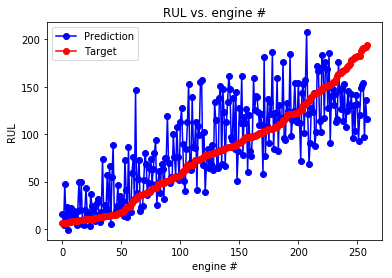

In [44]:
x     = range(0,259)
y_ts  = np.sort(Y_test[:,0])
idx   = np.argsort(Y_test[:,0])
y_tr  = y_hat[idx,0]
plt.plot(x, y_tr, 'bo-', x, y_ts, 'ro-')
plt.title('RUL vs. engine #')
plt.ylabel('RUL')
plt.xlabel('engine #')
plt.legend(['Prediction', 'Target'], loc='upper left')
plt.show()

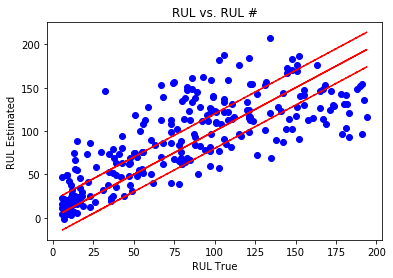

In [45]:
plt.plot(Y_test, y_hat, 'bo')
plt.plot(Y_test,Y_test, 'r-')
plt.plot(Y_test,Y_test+20, 'r--')
plt.plot(Y_test,Y_test-20, 'r--')
plt.title('RUL vs. RUL #')
plt.ylabel('RUL Estimated')
plt.xlabel('RUL True')
plt.show()